#Deep Sub-Ensembles for Fast Uncertainty Estimation in Image Classification

###EE639 Fall 2020 Final Project - Stephen Parsons, Kristina Gessel, Sairam Sri Vatsavai


This project is an implementation of [Deep Sub-Ensembles for Fast Uncertainty Estimation in Image Classification](http://bayesiandeeplearning.org/2019/papers/39.pdf). This paper was presented at the same [Bayesian Deep Learning NeurIPS 2019 Workshop](http://bayesiandeeplearning.org/) that hosted [the paper](http://bayesiandeeplearning.org/2019/papers/12.pdf) that proposed [the Diabetic Retinopathy Diagnosis benchmark](https://github.com/OATML/bdl-benchmarks/tree/alpha/baselines/diabetic_retinopathy_diagnosis). However, there is not yet an implementation of this paper’s ideas against this particular benchmark so this is a new application. The purpose of fast uncertainty estimation is what it sounds like: in certain applications, for example robotics, existing uncertainty estimation methods are prohibitively expensive. So, how much can we speed them up without large impacts to their performance? This paper proposes a method similar to [Deep Ensembles](https://arxiv.org/pdf/1612.01474.pdf), but where only the layers close to the output are used instead of the whole model. They report significant speedups with small decreases in uncertainty quality, allowing one to explore this tradeoff. The paper applies this method to two different image classification tasks, but it has not been tried with the Diabetic Retinopathy Diagnosis benchmark. We aim to reproduce their findings with this dataset.

# Prepare Dataset

In [ ]:
# Install some initial dependencies
!pip install --quiet tensorflow-gpu tensorflow-datasets
!pip install --quiet -U tensorflow-addons

# Mount Google Drive
# Make sure there is a shortcut to this folder (I have made it available to all)
# in your Drive (which will become /content/drive/MyDrive/tensorflow_datasets):
# https://drive.google.com/drive/folders/11EH9f8VqmrXafa42hwg-mNXgEtP0xfCQ?usp=sharing
# This contains all of the downloaded and prepared data.
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 320.4MB 54kB/s 
     |████████████████████████████████| 1.1MB 14.1MB/s 
Mounted at /content/drive


In [ ]:
import functools
import inspect
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import tensorflow.compat.v2 as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tqdm

# Construct a tf.data.Dataset
ds, info = tfds.load(
    'diabetic_retinopathy_detection/250K', 
    data_dir='/content/drive/MyDrive/tensorflow_datasets',
    shuffle_files=True,
    with_info=True,
    download=False,  # No need to download, already did that manually
)

# Function visualize_tfdataset adapted from bdl-benchmarks
# https://github.com/OATML/bdl-benchmarks/blob/alpha/notebooks/diabetic_retinopathy_diagnosis.ipynb
def visualize_tfdataset(tfdataset, num_samples):
  """Visualizes `num_samples` from the `tfdataset`."""
  
  def to01(image):
    """Normalizes image to float [0, 1]."""
    min_ = np.min(image)
    max_ = np.max(image)
    return (image - min_) / (max_ - min_)
  
  fig, axes = plt.subplots(figsize=(2.0*num_samples, 2.0), ncols=num_samples)
  for i, (img, label) in enumerate(tfdataset.take(num_samples)):
    img = img.numpy()
    label = label.numpy()
    ax = axes[i]
    ax.imshow(to01(img))
    ax.axis("off")
    ax.set(title=label)
  fig.show()

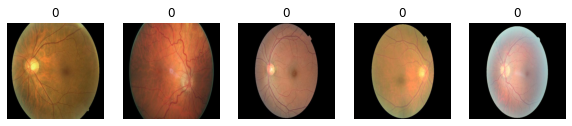

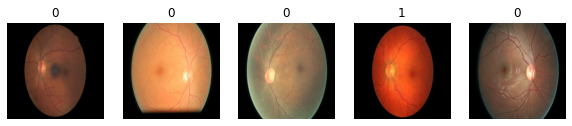

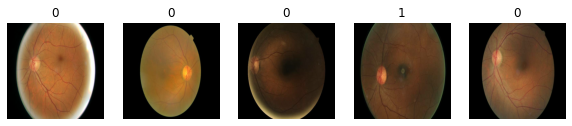

In [ ]:
input_shape = (512, 512, 3)
batch_size = 128

def make_supervised_pair(sample):
  img = sample['image']
  label = sample['label']
  return img, label

def augment(img, label):
  img = tf.image.resize(img, input_shape[:2])
  # Augmentation disabled for now - very expensive, and small perf improvement
  # TODO Standard normalize for each color channel separately
  # using empirical statistics of the training data

  # Random zooming by up to +/- 10%
  # zoom = tf.random.uniform((), 0.9, 1.1)
  # img = tfa.image.transform(img, [zoom, 0.0, 0.0,
  #                                 0.0, zoom, 0.0,
  #                                 0.0, 0.0])
  
  # Random translations (independent shifts of up to +/- 25 pixels)
  # tmax = 25
  # img = tfa.image.transform(img, [1.0, 0.0, tf.random.uniform((), -tmax, tmax),
  #                                 0.0, 1.0, tf.random.uniform((), -tmax, tmax),
  #                                 0.0, 0.0])
  
  # Random rotations (by up to +/- PI)
  # img = tfa.image.rotate(img, tf.random.uniform((), -np.pi, np.pi))
  
  # TODO Half of the data is flipped along horizontal and/or vertical axis

  # Transform five classes into binary healthy/unhealthy classification
  label = 0 if label < 2 else 1
  return img, label

ds_train = ds['train'].map(make_supervised_pair)
ds_validation = ds['validation'].map(make_supervised_pair)
ds_test = ds['test'].map(make_supervised_pair)

# visualize_tfdataset(ds_train, num_samples=5)
# visualize_tfdataset(ds_validation, num_samples=5)
# visualize_tfdataset(ds_test, num_samples=5)

ds_train = ds_train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_validation = ds_validation.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

visualize_tfdataset(ds_train, num_samples=5)
visualize_tfdataset(ds_validation, num_samples=5)
visualize_tfdataset(ds_test, num_samples=5)

ds_train = ds_train.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
ds_validation = ds_validation.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Define Model

In [ ]:
# Class VGGDrop adapted from bdl-benchmarks
# https://github.com/OATML/bdl-benchmarks/blob/9ca73d487b6741ff6ad8a20a3c06cb011bcc51ed/baselines/diabetic_retinopathy_diagnosis/mc_dropout/model.py
def VGGDrop(dropout_rate, num_base_filters, learning_rate, l2_reg, input_shape):
  """VGG-like model with dropout for diabetic retinopathy diagnosis.
  Args:
    dropout_rate: `float`, the rate of dropout, between [0.0, 1.0).
    num_base_filters: `int`, number of convolution filters in the
      first layer.
    learning_rate: `float`, ADAM optimizer learning rate.
    l2_reg: `float`, the L2-regularization coefficient.
    input_shape: `iterable`, the shape of the images in the input layer.
  Returns:
    A tensorflow.keras.Sequential VGG-like model with dropout.
  """
  # Feedforward neural network
  model = tfk.Sequential([
      tfkl.InputLayer(input_shape),
      # Block 1
      tfkl.Conv2D(filters=num_base_filters,
                  kernel_size=3,
                  strides=(2, 2),
                  padding="same",
                  kernel_regularizer=tfk.regularizers.l2(l2_reg)),
      tfkl.Activation("relu"),
      tfkl.Dropout(dropout_rate),
      tfkl.MaxPooling2D(pool_size=3, strides=(2, 2), padding="same"),
      # Block 2
      tfkl.Conv2D(filters=num_base_filters,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="same",
                  kernel_regularizer=tfk.regularizers.l2(l2_reg)),
      tfkl.Activation("relu"),
      tfkl.Dropout(dropout_rate),
      tfkl.Conv2D(filters=num_base_filters,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="same",
                  kernel_regularizer=tfk.regularizers.l2(l2_reg)),
      tfkl.Activation("relu"),
      tfkl.Dropout(dropout_rate),
      tfkl.MaxPooling2D(pool_size=3, strides=(2, 2), padding="same"),
      # Block 3
      tfkl.Conv2D(filters=num_base_filters * 2,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="same",
                  kernel_regularizer=tfk.regularizers.l2(l2_reg)),
      tfkl.Activation("relu"),
      tfkl.Dropout(dropout_rate),
      tfkl.Conv2D(filters=num_base_filters * 2,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="same",
                  kernel_regularizer=tfk.regularizers.l2(l2_reg)),
      tfkl.Activation("relu"),
      tfkl.Dropout(dropout_rate),
      tfkl.MaxPooling2D(pool_size=3, strides=(2, 2), padding="same"),
      # Block 4
      tfkl.Conv2D(filters=num_base_filters * 4,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="same",
                  kernel_regularizer=tfk.regularizers.l2(l2_reg)),
      tfkl.Activation("relu"),
      tfkl.Dropout(dropout_rate),
      tfkl.Conv2D(filters=num_base_filters * 4,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="same",
                  kernel_regularizer=tfk.regularizers.l2(l2_reg)),
      tfkl.Activation("relu"),
      tfkl.Dropout(dropout_rate),
      tfkl.Conv2D(filters=num_base_filters * 4,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="same",
                  kernel_regularizer=tfk.regularizers.l2(l2_reg)),
      tfkl.Activation("relu"),
      tfkl.Dropout(dropout_rate),
      tfkl.Conv2D(filters=num_base_filters * 4,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="same",
                  kernel_regularizer=tfk.regularizers.l2(l2_reg)),
      tfkl.Activation("relu"),
      tfkl.Dropout(dropout_rate),
      tfkl.MaxPooling2D(pool_size=3, strides=(2, 2), padding="same"),
      # Block 5
      tfkl.Conv2D(filters=num_base_filters * 8,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="same",
                  kernel_regularizer=tfk.regularizers.l2(l2_reg)),
      tfkl.Activation("relu"),
      tfkl.Dropout(dropout_rate),
      tfkl.Conv2D(filters=num_base_filters * 8,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="same",
                  kernel_regularizer=tfk.regularizers.l2(l2_reg)),
      tfkl.Activation("relu"),
      tfkl.Dropout(dropout_rate),
      tfkl.Conv2D(filters=num_base_filters * 8,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="same",
                  kernel_regularizer=tfk.regularizers.l2(l2_reg)),
      tfkl.Activation("relu"),
      tfkl.Dropout(dropout_rate),
      tfkl.Conv2D(filters=num_base_filters * 8,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="same",
                  kernel_regularizer=tfk.regularizers.l2(l2_reg)),
      tfkl.Activation("relu"),
      # Global poolings
      tfkl.Lambda(lambda x: tfk.backend.concatenate(
          [tfkl.GlobalAvgPool2D()
           (x), tfkl.GlobalMaxPool2D()(x)], axis=1)),
      # Fully-connected
      tfkl.Dense(1, kernel_regularizer=tfk.regularizers.l2(l2_reg)),
      tfkl.Activation("sigmoid")
  ])

  model.compile(loss=tfk.losses.BinaryCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.AUC()])

  return model

model = VGGDrop(dropout_rate=0.1, num_base_filters=32, learning_rate=4e-4,
                l2_reg=5e-5, input_shape=input_shape)

# Train Ensemble

In [ ]:
# In practice we did this independently various times and saved the resulting
# .h5 weights into a shared checkpoints directory.
# history = model.fit(
#     ds_train,
#     epochs=50,
#     validation_data=ds_validation,
#     validation_steps=5,
#     # class_weight={0: 1.0, 1: 4.0},
# )

# Uncertainty Estimators

In [ ]:
# Initialize dict to hold all methods
uncertainty_models = dict()

In [ ]:
# Deep Ensembles

# Load all model checkpoints to make an ensemble.
# (Ref: https://github.com/OATML/bdl-benchmarks/blob/alpha/baselines/diabetic_retinopathy_diagnosis/deep_ensembles/main.py)
model_checkpoint_dir = '/content/drive/MyDrive/checkpoints/ENSEMBLE_CHECKPOINTS'
# model_checkpoints = ['/content/drive/MyDrive/checkpoints/models/11.29.20:20:32.h5'] #add other models...
# Automatically list all model checkpoints
model_checkpoints = [f for f in os.listdir(model_checkpoint_dir) if f.endswith('.h5')]

DE_classifiers = list()
for checkpoint in model_checkpoints:
  checkpoint_path = os.path.join(model_checkpoint_dir, checkpoint)
  classifier = VGGDrop(dropout_rate=0.1, num_base_filters=32, learning_rate=4e-4,
                l2_reg=5e-5, input_shape=input_shape) #use the same hyperparameters as the initial training hyperparameters--assuming these are the same for all models
  classifier.load_weights(checkpoint_path)
  print(f'Loaded model from: {checkpoint_path}')
  # classifier.summary()
  DE_classifiers.append(classifier)

def deep_ensembles_predict(x, models, type="entropy"):
  """Deep Ensembles uncertainty estimator.
  Args:
    x: `numpy.ndarray`, datapoints from input space,
      with shape [B, H, W, 3], where B the batch size and
      H, W the input images height and width accordingly.
    models: `iterable` of `tensorflow.keras.Model`,
      a probabilistic model, which accepts input with
      shape [B, H, W, 3] and outputs sigmoid probability
      [0.0, 1.0], and also accepts boolean arguments
      `training=False` for disabling dropout at test time.
    type: (optional) `str`, type of uncertainty returns,
      one of {"entropy", "stddev"}.
  Returns:
    mean: `numpy.ndarray`, predictive mean, with shape [B].
    uncertainty: `numpy.ndarray`, ncertainty in prediction,
      with shape [B].
  """
  import numpy as np
  import scipy.stats

  # Get shapes of data
  B, _, _, _ = x.shape

  # Monte Carlo samples from different deterministic models
  mc_samples = np.asarray([model(x, training=False) for model in models
                          ]).reshape(-1, B)

  # Bernoulli output distribution
  dist = scipy.stats.bernoulli(mc_samples.mean(axis=0))

  # Predictive mean calculation
  mean = dist.mean()

  # Use predictive entropy for uncertainty
  if type == "entropy":
    uncertainty = dist.entropy()
  # Use predictive standard deviation for uncertainty
  elif type == "stddev":
    uncertainty = dist.std()
  else:
    raise ValueError(
        "Unrecognized type={} provided, use one of {'entropy', 'stddev'}".
        format(type))

  return mean, uncertainty

uncertainty_models['deep_ensembles'] = functools.partial(
    deep_ensembles_predict,
    models=DE_classifiers,
)

Loaded model from: /content/drive/MyDrive/checkpoints/ENSEMBLE_CHECKPOINTS/11.29.20:20:32.h5
Loaded model from: /content/drive/MyDrive/checkpoints/ENSEMBLE_CHECKPOINTS/11.29.20:20:52.h5
Loaded model from: /content/drive/MyDrive/checkpoints/ENSEMBLE_CHECKPOINTS/11.29.20:21:37.h5
Loaded model from: /content/drive/MyDrive/checkpoints/ENSEMBLE_CHECKPOINTS/11.29.20:22:03.h5
Loaded model from: /content/drive/MyDrive/checkpoints/ENSEMBLE_CHECKPOINTS/11.29.20:22:11.h5
Loaded model from: /content/drive/MyDrive/checkpoints/ENSEMBLE_CHECKPOINTS/11.29.20:22:06.h5
Loaded model from: /content/drive/MyDrive/checkpoints/ENSEMBLE_CHECKPOINTS/11.30.20:00:21.h5
Loaded model from: /content/drive/MyDrive/checkpoints/ENSEMBLE_CHECKPOINTS/11.30.20:15:00.h5
Loaded model from: /content/drive/MyDrive/checkpoints/ENSEMBLE_CHECKPOINTS/11.30.20:14:41.h5
Loaded model from: /content/drive/MyDrive/checkpoints/ENSEMBLE_CHECKPOINTS/11.30.20:14:53.h5


In [ ]:
# MC Dropout

# Function mc_dropout_uncertainty_predict adapted from bdl-benchmarks `predict`
# https://github.com/OATML/bdl-benchmarks/blob/9ca73d487b6741ff6ad8a20a3c06cb011bcc51ed/baselines/diabetic_retinopathy_diagnosis/mc_dropout/model.py
def mc_dropout_uncertainty_predict(x, model, num_samples, type="entropy"):
  """Monte Carlo dropout uncertainty estimator.
  Args:
    x: `numpy.ndarray`, datapoints from input space,
      with shape [B, H, W, 3], where B the batch size and
      H, W the input images height and width accordingly.
    model: `tensorflow.keras.Model`, a probabilistic model,
      which accepts input with shape [B, H, W, 3] and
      outputs sigmoid probability [0.0, 1.0], and also
      accepts boolean arguments `training=True` for enabling
      dropout at test time.
    num_samples: `int`, number of Monte Carlo samples
      (i.e. forward passes from dropout) used for
      the calculation of predictive mean and uncertainty.
    type: (optional) `str`, type of uncertainty returns,
      one of {"entropy", "stddev"}.
  Returns:
    mean: `numpy.ndarray`, predictive mean, with shape [B].
    uncertainty: `numpy.ndarray`, ncertainty in prediction,
      with shape [B].
  """
  # Get shapes of data
  B, _, _, _ = x.shape

  # Monte Carlo samples from different dropout mask at test time
  mc_samples = np.asarray([model(x, training=True) for _ in range(num_samples)
                          ]).reshape(-1, B)

  # Bernoulli output distribution
  dist = scipy.stats.bernoulli(mc_samples.mean(axis=0))

  # Predictive mean calculation
  mean = dist.mean()

  # Use predictive entropy for uncertainty
  if type == "entropy":
    uncertainty = dist.entropy()
  # Use predictive standard deviation for uncertainty
  elif type == "stddev":
    uncertainty = dist.std()
  else:
    raise ValueError(
        "Unrecognized type={} provided, use one of {'entropy', 'stddev'}".
        format(type))

  return mean, uncertainty

uncertainty_models['mc_dropout'] = functools.partial(
    mc_dropout_uncertainty_predict,
    model=DE_classifiers[0],  # Just use the first one, it will be different each time due to MC Dropout
    num_samples=10,
)

In [ ]:
# Deterministic

def deterministic_predict(x, model, type="entropy"):
  """Simple sigmoid uncertainty estimator.
  Args:
    x: `numpy.ndarray`, datapoints from input space,
      with shape [B, H, W, 3], where B the batch size and
      H, W the input images height and width accordingly.
    model: `tensorflow.keras.Model`, a probabilistic model,
      which accepts input with shape [B, H, W, 3] and
      outputs sigmoid probability [0.0, 1.0], and also
      accepts boolean arguments `training=False` for
      disabling dropout at test time.
    type: (optional) `str`, type of uncertainty returns,
      one of {"entropy", "stddev"}.
  Returns:
    mean: `numpy.ndarray`, predictive mean, with shape [B].
    uncertainty: `numpy.ndarray`, ncertainty in prediction,
      with shape [B].
  """
  import numpy as np
  import scipy.stats

  # Get shapes of data
  B, _, _, _ = x.shape

  # Single forward pass from the deterministic model
  p = model(x, training=False)

  # Bernoulli output distribution
  dist = scipy.stats.bernoulli(p)

  # Predictive mean calculation
  mean = dist.mean()

  # Use predictive entropy for uncertainty
  if type == "entropy":
    uncertainty = dist.entropy()
  # Use predictive standard deviation for uncertainty
  elif type == "stddev":
    uncertainty = dist.std()
  else:
    raise ValueError(
        "Unrecognized type={} provided, use one of {'entropy', 'stddev'}".
        format(type))

  return mean, uncertainty

uncertainty_models['deterministic'] = functools.partial(
    deterministic_predict,
    model=DE_classifiers[0],
)

In [ ]:
def ensemble_mc_dropout_predict(x, models, num_samples, type="entropy"):
  """Deep Ensembles uncertainty estimator.
  Args:
    x: `numpy.ndarray`, datapoints from input space,
      with shape [B, H, W, 3], where B the batch size and
      H, W the input images height and width accordingly.
    num_samples: `int`, number of Monte Carlo samples
      (i.e. forward passes from dropout) used for
      the calculation of predictive mean and uncertainty.
    type: (optional) `str`, type of uncertainty returns,
      one of {"entropy", "stddev"}.
    models: `iterable` of `tensorflow.keras.Model`,
      a probabilistic model, which accepts input with shape
      [B, H, W, 3] and outputs sigmoid probability [0.0, 1.0],
      and also accepts boolean arguments `training=True` for
      enabling dropout at test time.
  Returns:
    mean: `numpy.ndarray`, predictive mean, with shape [B].
    uncertainty: `numpy.ndarray`, ncertainty in prediction,
      with shape [B].
  """
  import numpy as np
  import scipy.stats

  # Get shapes of data
  B, _, _, _ = x.shape

  # Monte Carlo samples from different dropout mask at test time from different models
  mc_samples = np.asarray([
      model(x, training=True) for _ in range(num_samples) for model in models
  ]).reshape(-1, B)

  # Bernoulli output distribution
  dist = scipy.stats.bernoulli(mc_samples.mean(axis=0))

  # Predictive mean calculation
  mean = dist.mean()

  # Use predictive entropy for uncertainty
  if type == "entropy":
    uncertainty = dist.entropy()
  # Use predictive standard deviation for uncertainty
  elif type == "stddev":
    uncertainty = dist.std()
  else:
    raise ValueError(
        "Unrecognized type={} provided, use one of {'entropy', 'stddev'}".
        format(type))

  return mean, uncertainty

uncertainty_models['ensemble_mc_dropout'] = functools.partial(
    ensemble_mc_dropout_predict,
    models=DE_classifiers,
    num_samples=10,
)

# Define Evaluation

In [ ]:
from typing import Callable
from typing import Dict
from typing import Optional
from typing import Sequence
from typing import Text
from typing import Tuple
from typing import Union

def evaluate_metric(
      y_true: np.ndarray,
      y_pred: np.ndarray,
      y_uncertainty: np.ndarray,
      fractions: Sequence[float],
      metric_fn: Callable[[np.ndarray, np.ndarray], float],
      name=None,
  ) -> pd.DataFrame:
    """Evaluate model predictive distribution on `metric_fn` at data retain
    `fractions`.
    Args:
      y_true: `numpy.ndarray`, the ground truth labels, with shape [N].
      y_pred: `numpy.ndarray`, the model predictions, with shape [N].
      y_uncertainty: `numpy.ndarray`, the model uncertainties,
        with shape [N].
      fractions: `iterable`, the percentages of data to retain for
        calculating `metric_fn`.
      metric_fn: `lambda(y_true, y_pred) -> float`, a metric
        function that provides a score given ground truths
        and predictions.
      name: (optional) `str`, the name of the method.
    Returns:
      A `pandas.DataFrame` with columns ["retained_data", "mean", "std"],
      that summarizes the scores at different data retained fractions.
    """

    N = y_true.shape[0]

    # Sorts indexes by ascending uncertainty
    I_uncertainties = np.argsort(y_uncertainty)

    # Score containers
    mean = np.empty_like(fractions)
    # TODO(filangel): do bootstrap sampling and estimate standard error
    std = np.zeros_like(fractions)

    for i, frac in enumerate(fractions):
      # Keep only the %-frac of lowest uncertainties
      I = np.zeros(N, dtype=bool)
      I[I_uncertainties[:int(N * frac)]] = True
      mean[i] = metric_fn(y_true[I], y_pred[I])

    # Store
    df = pd.DataFrame(dict(retained_data=fractions, mean=mean, std=std))
    df.name = name

    return df

def evaluate(
      estimator: Callable[[np.ndarray], Tuple[np.ndarray, np.ndarray]],
      dataset: tf.data.Dataset,
      fractions: Sequence[float],
      name: Optional[Text] = None,
  ) -> Dict[Text, float]:
    """Evaluates an `estimator` on the `mode` benchmark dataset.
    Args:
      estimator: `lambda x: mu_x, uncertainty_x`, an uncertainty estimation
        function, which returns `mean_x` and predictive `uncertainty_x`.
      dataset: `tf.data.Dataset`, on which dataset to performance evaluation.
      output_dir: (optional) `str`, directory to save figures.
      name: (optional) `str`, the name of the method.
    """
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import accuracy_score

    # Containers used for caching performance evaluation
    y_true = list()
    y_pred = list()
    y_uncertainty = list()

    # Convert to NumPy iterator if necessary
    ds = dataset if inspect.isgenerator(dataset) else tfds.as_numpy(dataset)

    for x, y in tqdm.notebook.tqdm(ds):
      # Sample from probabilistic model
      mean, uncertainty = estimator(x)
      # Cache predictions
      y_true.append(y)
      y_pred.append(mean)
      y_uncertainty.append(uncertainty)

    # Use vectorized NumPy containers
    y_true = np.concatenate(y_true).flatten()
    y_pred = np.concatenate(y_pred).flatten()
    y_uncertainty = np.concatenate(y_uncertainty).flatten()

    metrics = zip(
        ["accuracy", "auc"],
        [tfk.metrics.BinaryAccuracy(), tfk.metrics.AUC()]
    )

    return {
        metric: evaluate_metric(
            y_true,
            y_pred,
            y_uncertainty,
            fractions,
            lambda y_true, y_pred: metric_fn(y_true, y_pred).numpy(),
            name,
        ) for (metric, metric_fn) in metrics
    }

# Perform Evaluation

In [ ]:
# The assumes path for stored baselines records
leaderboard_dir = '/content/drive/MyDrive/leaderboard'
benchmark = 'diabetic_retinopathy_diagnosis'
benchmark_dir = os.path.join(leaderboard_dir, benchmark)
if not os.path.exists(benchmark_dir):
  ValueError('No leaderboard data found at {}'.format(benchmark_dir))
    
fractions = np.asarray([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

eval_batches = 20
for method_name, method_fn in uncertainty_models.items():
  print(f'Evaluating {method_name}:')
  res = evaluate(method_fn, ds_test.take(eval_batches), fractions=fractions, name=method_name)
  for metric in res:
    # Save .csv to Drive
    res[metric].to_csv(os.path.join(benchmark_dir, metric, method_name + '.csv'))

Evaluating deep_ensembles:



Evaluating mc_dropout:



Evaluating deterministic:



Evaluating ensemble_mc_dropout:


In [ ]:
# #All models have equal depth of 13 layers?
# classifiers = list()
# for checkpoint in model_checkpoints:
#   classifier = VGGDrop(dropout_rate=0.1, num_base_filters=32, learning_rate=4e-4,
#                 l2_reg=5e-5, input_shape=input_shape) #use the same hyperparameters as the initial training hyperparameters--assuming these are the same for all models

#   #Freeze all layers at first because load weights will act odd if you don't (https://stackoverflow.com/questions/46610732/how-to-freeze-some-layers-when-fine-tune-resnet50)
#   for layer in classifier.layers:
#     layer.trainable = False
#     print(layer.name) #debug

#   classifier.load_weights(checkpoint)

#   #Un-freeze the last three(?) layers (specify task network)
#   for layer in classifier.layers[-11:]:
#     print("unfroze ", layer.name) #debug
#     layer.trainable = True

#   #classifier.summary()
#   classifiers.append(classifier)

# trained_sub_ensembles = list()

# #Train every model 
# for classifier in classifiers:
#   #randomly initialize only the task network layers -- leave trunk layers alone
#   #train the network (with trunk layers frozen and task network layers unfrozen and randomly initialized) on the dataset.
#   #add trained network to the set of sub-ensembles

# Plot Results (Leaderboard)

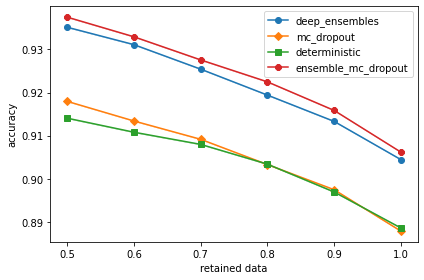

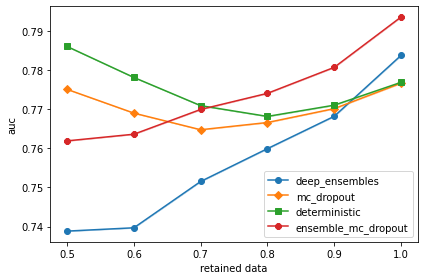

In [ ]:
def leaderboard(
    benchmark_dir,
    results: Optional[Dict[Text, pd.DataFrame]] = None,
    output_dir: Optional[Text] = None,
    leaderboard_dir: Optional[Text] = None,
    **ax_set_kwargs,
):
  """Generates a leaderboard for all metrics in `benchmark`, by appending the
  (optional) `results`.

  Args:
    benchmark: `str`, the registerd name of `bdlb.Benchmark`.
    results: (optional) `dict`, dictionary of `pandas.DataFrames`
      with the results from a new method to be plotted against
      the leaderboard.
    output_dir: (optional) `str`, the directory name to
      store the figures.
  """
  COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
  MARKERS = ['o', 'D', 's', '8', '^', '*']

  # Metrics for which values are stored
  metrics = [
      x for x in os.listdir(benchmark_dir) if os.path.isdir(os.path.join(benchmark_dir, x))
  ]
  for metric in metrics:
    fig, ax = plt.subplots()
    # Iterate over baselines
    baselines = [
        x for x in os.listdir(os.path.join(benchmark_dir, metric))
        if '.csv' in x
    ]

    for b, baseline in enumerate(baselines):
      baseline = baseline.replace('.csv', '')
      # Fetch results
      df = pd.read_csv(
          os.path.join(benchmark_dir, metric, '{}.csv'.format(baseline)))
      # Parse columns
      retained_data = df['retained_data']
      mean = df['mean']
      std = df['std']
      # Visualize mean with standard error
      ax.plot(
          retained_data,
          mean,
          label=baseline,
          color=COLORS[b % len(COLORS)],
          marker=MARKERS[b % len(MARKERS)],
      )
      ax.fill_between(
          retained_data,
          mean - std,
          mean + std,
          color=COLORS[b % len(COLORS)],
          alpha=0.25,
      )
    if results is not None:
      # Plot results from dictionary
      if metric in results:
        df = results[metric]
        baseline = df.name if hasattr(df, 'name') else 'new_method'
        # Parse columns
        retained_data = df['retained_data']
        mean = df['mean']
        std = df['std']
        # Visualize mean with standard error
        ax.plot(
            retained_data,
            mean,
            label=baseline,
            color=COLORS[(b + 1) % len(COLORS)],
            marker=MARKERS[(b + 1) % len(MARKERS)],
        )
        ax.fill_between(
            retained_data,
            mean - std,
            mean + std,
            color=COLORS[(b + 1) % len(COLORS)],
            alpha=0.25,
        )
    ax.set(xlabel='retained data', ylabel=metric)
    ax.legend()
    fig.tight_layout()
    if isinstance(output_dir, str):
      os.makedirs(output_dir, exist_ok=True)
      fig.savefig(
          os.path.join(output_dir, '{}.pdf'.format(metric)),
          trasparent=True,
          dpi=300,
          format='pdf',
      )
      plt.show()

leaderboard(benchmark_dir)

# Demo

Evaluating deep_ensembles:



Evaluating mc_dropout:



Evaluating deterministic:



Evaluating ensemble_mc_dropout:


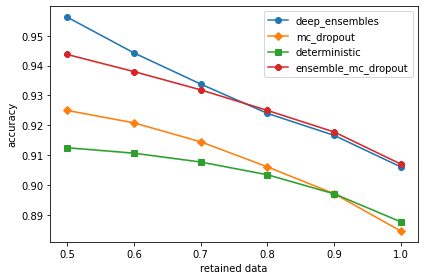

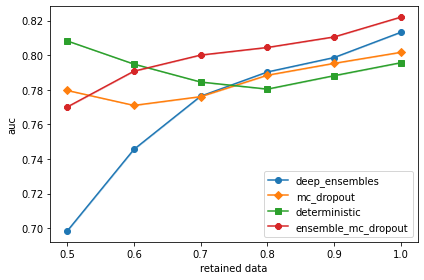

In [ ]:
# The assumes path for stored baselines records
leaderboard_dir = '/content/drive/MyDrive/leaderboard'
demo_benchmark = 'diabetic_retinopathy_diagnosis_demo'
demo_benchmark_dir = os.path.join(leaderboard_dir, demo_benchmark)
if not os.path.exists(demo_benchmark_dir):
  ValueError('No leaderboard data found at {}'.format(demo_benchmark_dir))
    
fractions = np.asarray([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

demo_batches = 5
for method_name, method_fn in uncertainty_models.items():
  print(f'Evaluating {method_name}:')
  res = evaluate(method_fn, ds_test.take(demo_batches), fractions=fractions, name=method_name)
  for metric in res:
    # Save .csv to Drive
    res[metric].to_csv(os.path.join(demo_benchmark_dir, metric, method_name + '.csv'))

leaderboard(demo_benchmark_dir)

# TODO

In [ ]:
# TODO
# Here is a list of things I was considering doing next

# - [X] Figure out why the above model does not seem to be learning during training
# - [ ] Calculate correct class_weight for class imbalances and make use of it https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# - [X] When download_and_prepare() is done, upload the 250K version of the dataset and try using that
# - [ ] Once the models seem to be learning well, train multiple (~10? ~100?) models and save the weights to be used for deep ensembles
# - [X] Copy over some of the utilities from bdl-benchmarks to make plots based on retained data
# - [ ] Implement MC dropout and deep ensembles as baselines and plot results (both simple)
# - [ ] Implement deep sub-ensembles and plot results